In [15]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_44'

# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [16]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_rpy = np.load(stats_dir / 'base_rpy.npy')
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_rpy': base_rpy,
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [17]:
def plot_xy_coordinates(ax, stats):
    base_pos = stats['base_pos']
    xs = base_pos[:,0]
    ys = base_pos[:,1]

    ax.plot(xs, ys)
    ax.set_xlabel('Forward distance travelled (m)')
    ax.set_ylabel('Lateral deviation (m)')
    ax.axhline(0.0, color = 'black', alpha =0.3, linestyle='--')

def plot_heading(stats):
    base_pos = stats['base_pos']
    base_rpy = stats['base_rpy']
    xs = base_pos[:,0]
    yaws = base_rpy[:,2]

    plt.figure()
    plt.plot(xs, yaws)

def load_thrown_object_times():
    import csv
    obj_thrown_times = []
    with open('object_thrown_time.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            obj_thrown_times.append(row[0])
        return obj_thrown_times

In [18]:

statss = []
for seed in range(20):
    stats_dir = model_dir / f'throw-obj-platform-seed{seed}'
    # child_dirs = [p for p in stats_dir.iterdir() if p.is_dir()]
    stats = load_robot_states(stats_dir)
    stats['name'] = f'seed{seed}'
    statss.append(stats)

(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(1717, 1, 108)
(1743, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(2606, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)


# Create plots of y-position, heading

Survival rate:  0.85


/tmp/ipykernel_18871/3816366418.py:78: RuntimeWarning: invalid value encountered in double_scalars
  return (y_curr * (x_curr - x_query) + y_last * (x_query - x_last)) / (x_curr - x_last)
/tmp/ipykernel_18871/3816366418.py:124: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("robustness_thrown_platforms.pdf", format="pdf", bbox_layout="tight")


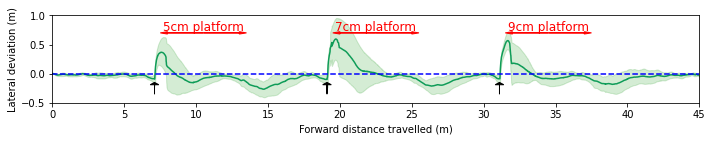

In [19]:
import matplotlib.pyplot as plt

NUM_TIMESTEPS = 200

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_red = (219 / 256, 68 / 256, 55 / 256, 1)
google_yellow = (244 / 256, 180 / 256, 0, 1)
google_green = (15 / 256, 157 / 256, 88 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_red, google_yellow, google_green]
obstacle_pos = [(7.5, 13.5), (19.5, 25.5), (31.5, 37.5)]
obstacle_names = ('5cm platform', '7cm platform', '9cm platform')
# throw_directions = [1, -1, -1, 1, 1, -1]
throw_directions = [1, 1, 1, 1, 1, 1]
platform_heights = [0.05, 0.07, 0.09]

def plot_arrows(ax):
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.5, 1.0)
    throw_idx = 0
    for i, (start, end) in enumerate(obstacle_pos):
        # ax.axvspan(start, end, color='gray', alpha=0.2)
        draw_spanning_arrow(ax, start, 0.7, end, 0.7, name=obstacle_names[i])
        #ax.axvline(start - 1, color = 'black', linestyle = '--')
        if throw_directions[throw_idx] == 1: 
            draw_up_arrow(ax, start)
        else: draw_down_arrow(ax, start)
        throw_idx += 1
        #ax.axvline(end - 1, color = 'black', linestyle = '--')
        # if throw_directions[throw_idx] == 1: 
        #    draw_up_arrow(ax, end)
        #else: draw_down_arrow(ax, end)
        throw_idx += 1
    
def draw_up_arrow(ax, x):
    ax.arrow(x -0.4, -0.35, 0, 0.2, length_includes_head=True, head_width=0.6, head_length=0.04, color='black')

def draw_down_arrow(ax, x):
    ax.arrow(x -0.4, 0.35, 0, -0.2, length_includes_head=True, head_width=0.6, head_length=0.04, color='black')

def draw_spanning_arrow(ax, x1, y1, x2, y2, name=""):
    xmid = (x1 + x2) / 2 
    ymid = (y1 + y2) / 2

    xdiff = xmid - x1 
    ydiff = ymid - y2

    ax.text(xmid, ymid + 0.1, name, horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
    ax.arrow(xmid, ymid, xdiff, ydiff, color='red', length_includes_head=True, head_width=0.04, head_length=0.5)
    ax.arrow(xmid, ymid, -xdiff, -ydiff, color='red', length_includes_head=True, head_width=0.04, head_length=0.5)


def plot_xy_coordinates(ax, stats):
    base_pos = stats['base_pos']
    xs = base_pos[:,0]
    ys = base_pos[:,1]

    ax.plot(xs, ys)
    ax.set_xlabel('Forward displacement (m)')
    ax.set_ylabel('Lateral displacement (m)')
    ax.axhline(0.0, color = 'black', alpha =0.3, linestyle='--')

def get_interpolate_value(x, y, x_query):
    idx_last = None
    x_last = None
    for idx_curr, x_curr in enumerate(x):
        if x_query > x_curr:
            idx_last = idx_curr
            x_last = x_curr
        else:
            break
    if idx_curr >= len(x):
        return np.NaN
    y_last = y[idx_last]
    y_curr = y[idx_curr]

    return (y_curr * (x_curr - x_query) + y_last * (x_query - x_last)) / (x_curr - x_last) 

def plot_xy_coordinates_distribution(ax, statss):
    xs = []
    ys = []
    survivals = []
    for stats in statss:
        base_pos = stats['base_pos']
        nrows = base_pos.shape[0]
        base_pos = np.pad(base_pos, ((0, 3000 - nrows), (0, 0)), constant_values=np.NaN)
        survivals.append(0 if nrows < 3000 else 1)
        if base_pos[0,0] > 0: continue
        xs.append(base_pos[:,0])
        ys.append(base_pos[:,1])

    print("Survival rate: ", np.mean(survivals))        

    # Arbitrarily define x-indices for plotting
    x_plot = np.linspace(0.001, 45, num = 4000)
    y_mean = []
    y_std = []
    # Obtain the interpolated y-values to calculate mean and stdev
    for i, x_query in enumerate(x_plot):
        y_querys = []
        for x, y in zip(xs, ys):
            y_querys.append(get_interpolate_value(x, y, x_query.item()))
        y_mean.append(np.nanmean(y_querys))
        y_std.append(np.nanstd(y_querys))

    y_mean = np.array(y_mean)
    y_std = np.array(y_std)

    ax.plot(x_plot, y_mean, color=google_green)
    ax.axhline(0.0, color = 'blue', linestyle='--')
    ax.fill_between(x_plot, y_mean + y_std, y_mean - y_std, color='tab:green', alpha=0.2)
    #ax[1].plot(x_plot, y_std)
    #ax[1].plot(x_plot, survival_rate)

fig, ax = plt.subplots(figsize=(10,2.0))
ax.set_xlabel('Forward distance travelled (m)')
ax.set_ylabel('Lateral deviation (m)')
# ax.set_ylabel('Survival rate')
# ax[1].set_ylim(0.0, 1.1)
plot_arrows(ax)
plot_xy_coordinates_distribution(ax, statss)
fig.tight_layout()
fig.savefig("robustness_thrown_platforms.pdf", format="pdf", bbox_layout="tight")

# Generate plot for Hurdles environment

In [20]:
statss = []
for seed in range(10):
    stats_dir = model_dir / f'throw-obj-hurdle-seed{seed}'
    stats = load_robot_states(stats_dir)
    stats['name'] = f'seed{seed}'
    statss.append(stats)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dtch1997/github/mcx-lab/rl-baselines3-zoo/logs/ppo/A1GymEnv-v0_44/throw-obj-hurdle-seed0/base_rpy.npy'

Survival rate:  1.0


/tmp/ipykernel_23958/2484995672.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("robustness_thrown_hurdles.pdf", format="pdf", bbox_layout="tight")


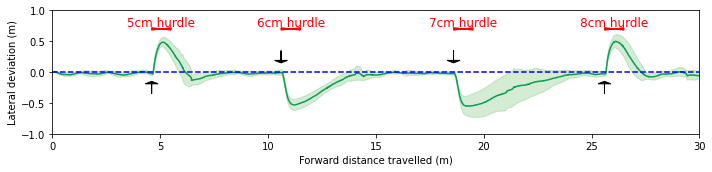

In [ ]:
import matplotlib.pyplot as plt

obstacle_pos = [5.0, 11.0, 19.0, 26.0]
obstacle_names = ('5cm hurdle', '6cm hurdle', '7cm hurdle', '8cm hurdle')
throw_directions = [1, -1, -1, 1, 1, -1]



def plot_hurdle_arrows(ax):
    ax.set_xlim(0, 30)
    ax.set_ylim(-1.0, 1.0)
    throw_idx = 0
    for i, start in enumerate(obstacle_pos):
        # ax.axvspan(start, end, color='gray', alpha=0.2)
        draw_spanning_arrow(ax, start, 0.7, start+0.1, 0.7, name=obstacle_names[i])
        if throw_directions[throw_idx] == 1: 
            draw_up_arrow(ax, start)
        else: draw_down_arrow(ax, start)
        throw_idx += 1

fig, ax = plt.subplots(figsize=(10,2.5))
ax.set_xlabel('Forward distance travelled (m)')
ax.set_ylabel('Lateral deviation (m)')
# ax[1].set_ylabel('Survival rate')
# ax[1].set_ylim(0.0, 1.1)
plot_hurdle_arrows(ax)
plot_xy_coordinates_distribution(ax, statss)
fig.tight_layout()
fig.savefig("robustness_thrown_hurdles.pdf", format="pdf", bbox_layout="tight")

In [ ]:
statss = []
for seed in range(10):
    stats_dir = model_dir / f'throw-obj-heightfield-seed{seed}'
    stats = load_robot_states(stats_dir)
    stats['name'] = f'seed{seed}'
    statss.append(stats)

(3000, 1, 108)
(3000, 1, 108)
(537, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)
(3000, 1, 108)


Survival rate:  0.9


/tmp/ipykernel_23958/1294487305.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("robustness_thrown_heightfield.pdf", format="pdf", bbox_layout="tight")


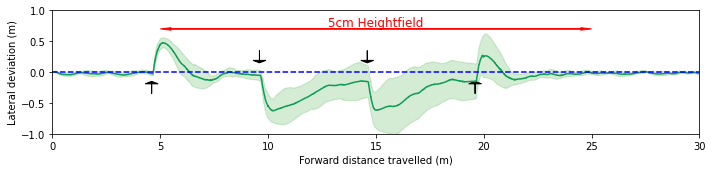

In [ ]:
import matplotlib.pyplot as plt

obstacle_pos = [5, 10, 15, 20]
throw_directions = [1, -1, -1, 1, 1, -1]

def plot_hurdle_arrows(ax):
    ax.set_xlim(0, 30)
    ax.set_ylim(-1.0, 1.0)
    throw_idx = 0
    draw_spanning_arrow(ax, 5.0, 0.7, 25.0, 0.7, name='5cm Heightfield')
    for i, start in enumerate(obstacle_pos):
        # ax.axvspan(start, end, color='gray', alpha=0.2)
        if throw_directions[throw_idx] == 1: 
            draw_up_arrow(ax, start)
        else: draw_down_arrow(ax, start)
        throw_idx += 1

fig, ax = plt.subplots(figsize=(10,2.5))
ax.set_xlabel('Forward distance travelled (m)')
ax.set_ylabel('Lateral deviation (m)')
# ax[1].set_ylabel('Survival rate')
# ax[1].set_ylim(0.0, 1.1)
plot_hurdle_arrows(ax)
plot_xy_coordinates_distribution(ax, statss)
fig.tight_layout()
fig.savefig("robustness_thrown_heightfield.pdf", format="pdf", bbox_layout="tight")